In [1]:
import pygmt

region = [16.2838, 16.4987, 48.1322, 48.2809]; res = '01s' # Vienna
region = [-75.7140, -75.4459, 6.0586, 6.3850]; res= '30s' # Medellin
#region = [12.2899, 12.4325, 46.0854, 46.2000]; res = '01s' # Alpago
#region = [12.2649, 12.4043, 45.9879, 46.1936]; res = '01s' # Alpago + Faldalto

# Load sample earth relief data
grid = pygmt.datasets.load_earth_relief(resolution = res, region = region)

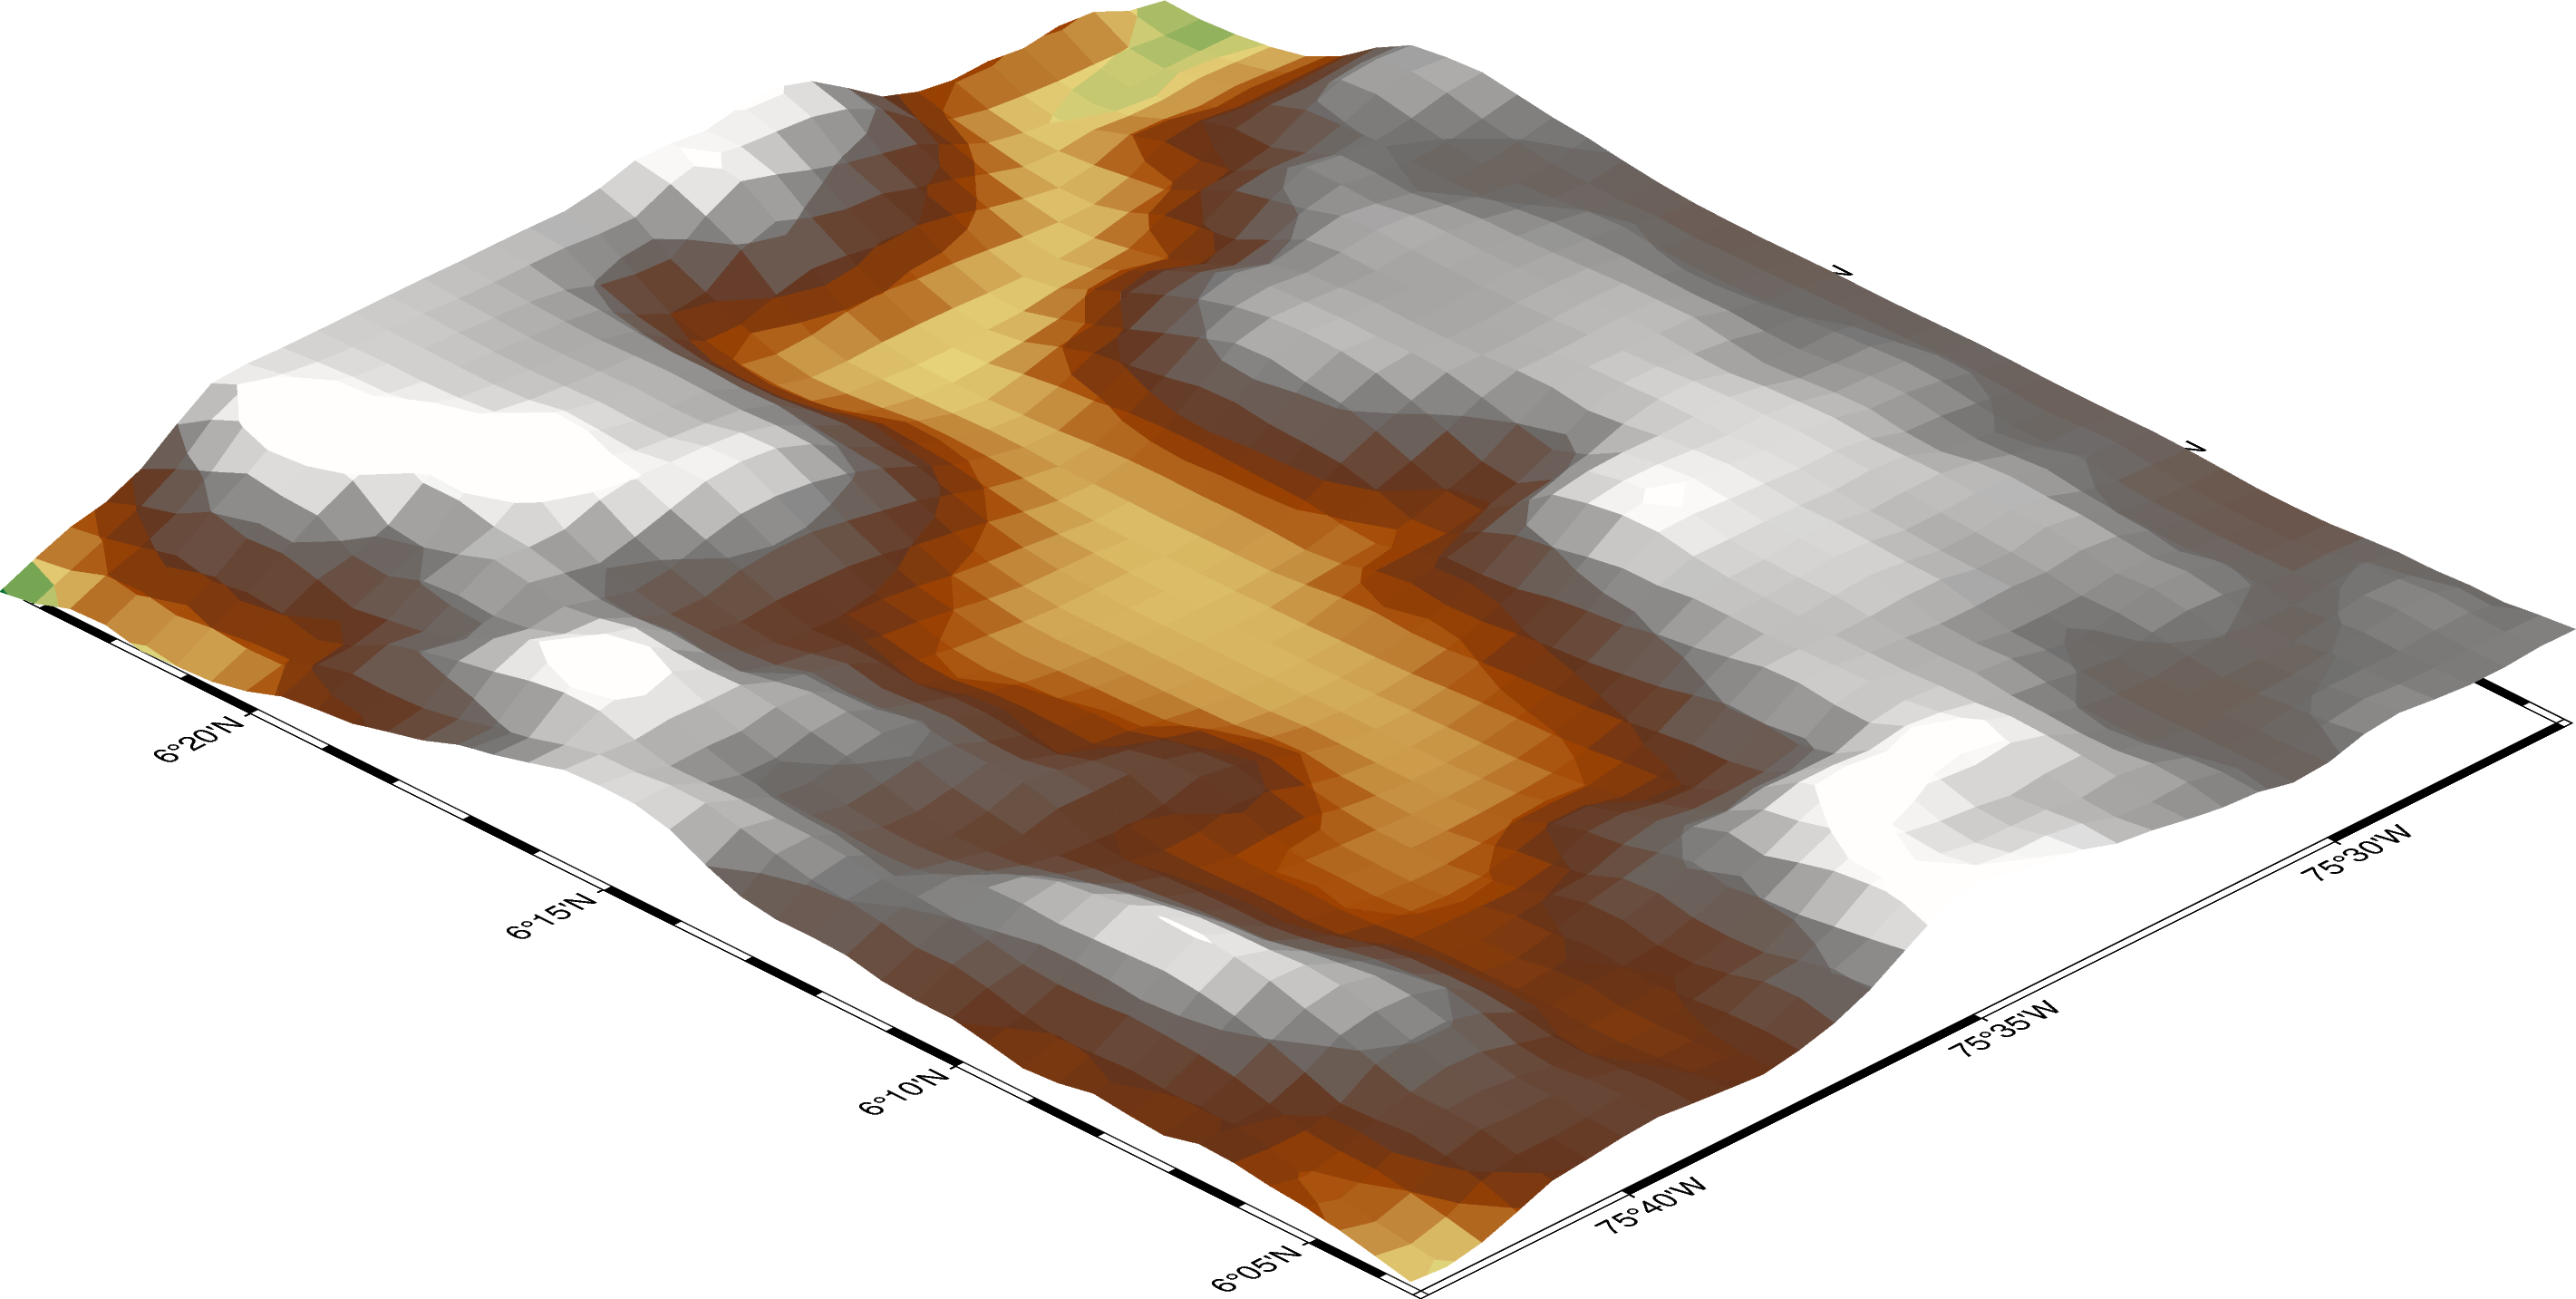

In [2]:
fig = pygmt.Figure()
fig.grdview(
    grid=grid,
    perspective=[225, 30],
    frame=["xa", "yaf", "WSnE"],
    projection="M15c",
    zsize="1.5c",
    # Set the surftype to "surface"
    surftype="s",
    # Set the CPT to "geo"
    cmap="geo",
)
fig.show()

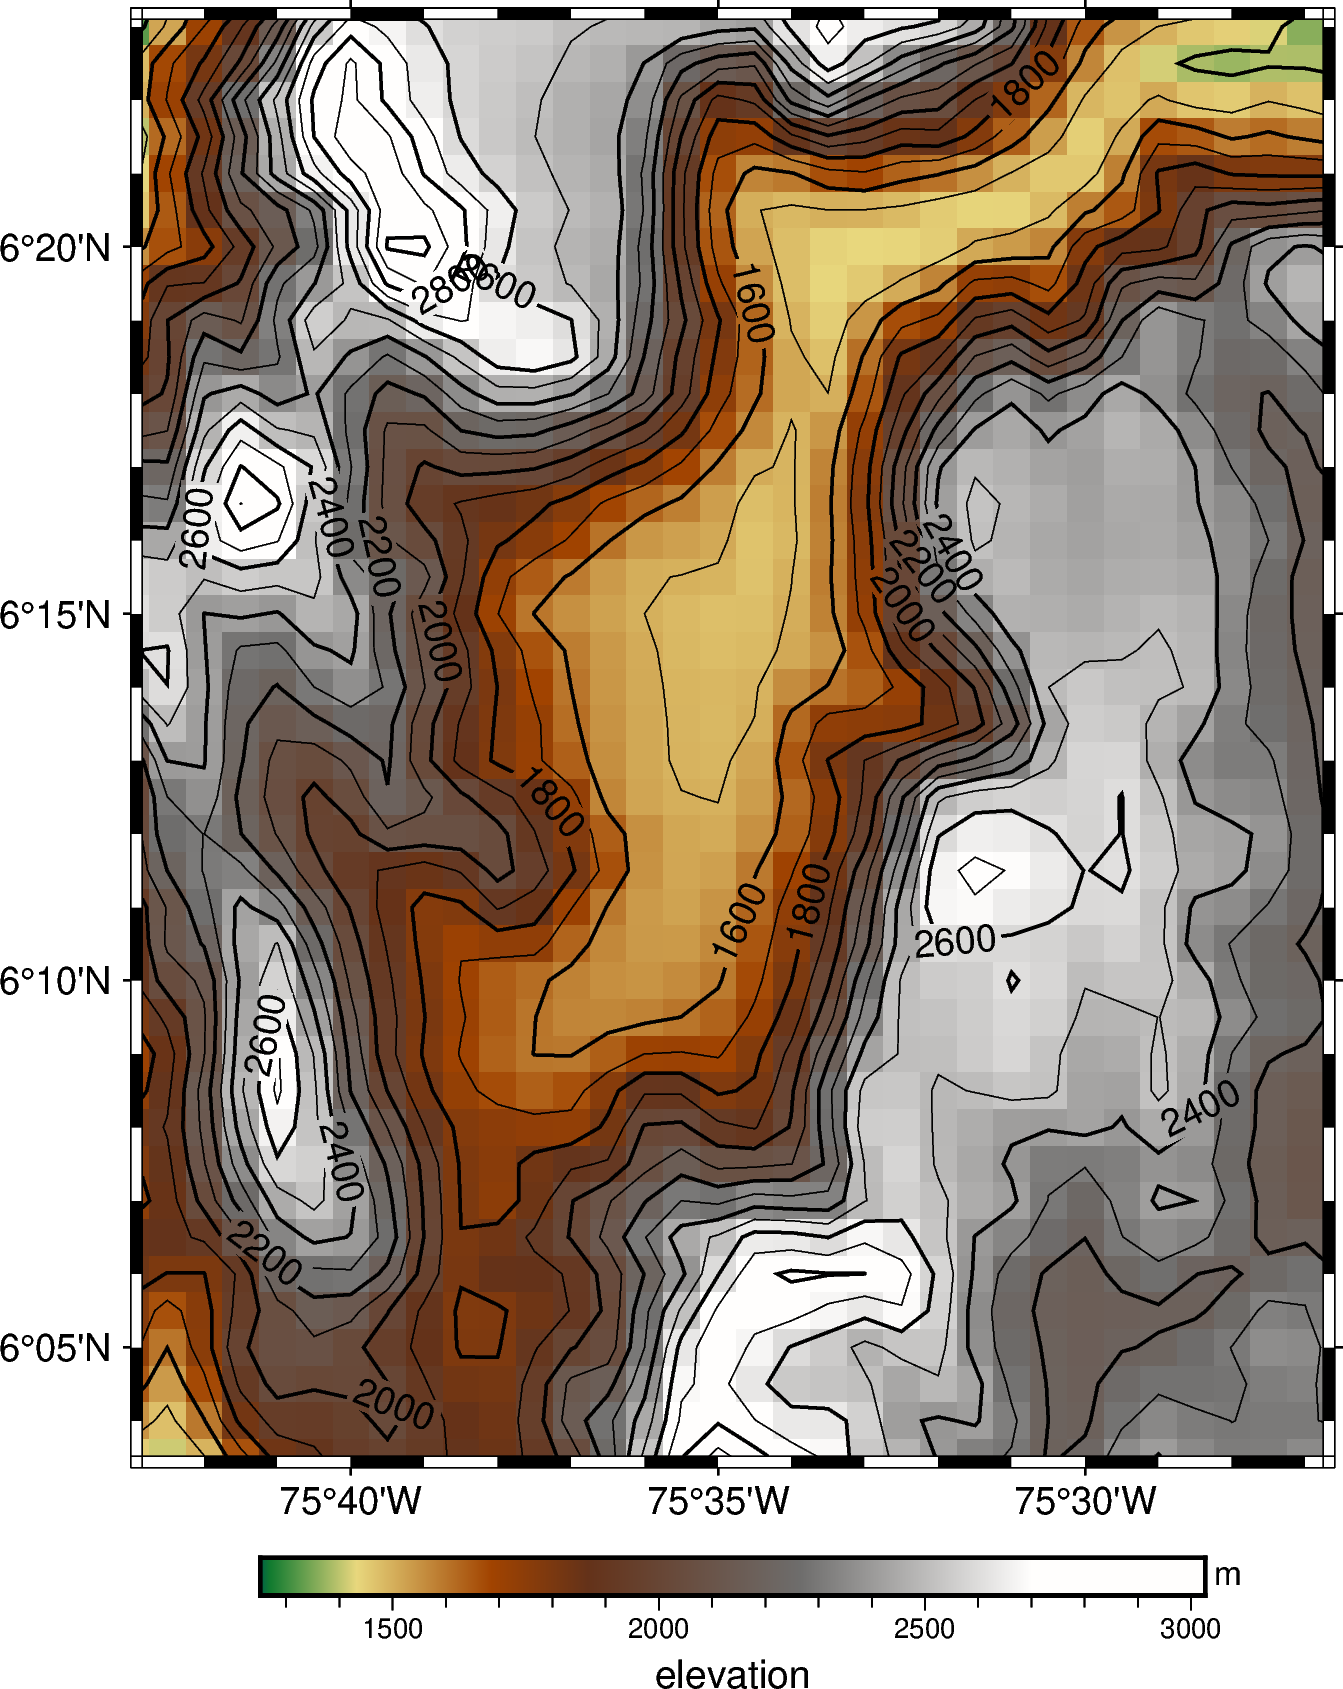

In [3]:
fig = pygmt.Figure()
fig.grdimage(grid=grid, cmap="geo", projection="M10c", frame=True)
fig.grdcontour(grid=grid,
               annotation=200,
               levels=100)
fig.colorbar(frame=["x+lelevation", "y+lm"])
fig.savefig('./heat_altitude.png', dpi=300)
fig.show()

# Build Metro NW from nodelist

In [4]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [5]:
# The order of the 94 rows is important! Links are placed between consecutive nodes in the same line (i.e. no more than 93 links are possible)
metro_df = pd.read_csv('./metro_coordinates_new.csv')
metro_df

,stop,line,type,lat,lon
0,Niquia,A,Metro,6.337891,-75.544242
1,Bello,A,Metro,6.329956,-75.553739
2,Madera,A,Metro,6.315904,-75.555362
3,Acevedo,A,Metro,6.299898,-75.558592
4,Tricentenario,A,Metro,6.290357,-75.564717
...,...,...,...,...,...
89,Alejandro Echavarria,T-A,Tramway,6.237420,-75.541562
90,Oriente,T-A,Tramway,6.234861,-75.540188
91,Oriente,H,Cable,6.233474,-75.539917
92,Las Torres,H,Cable,6.236893,-75.536266


In [6]:
# Extract relevant columns
metro_stops = metro_df[['stop', 'line', 'lat', 'lon']]

# Create a graph
G = nx.Graph()

# Add nodes and edges to the graph
for index, row in metro_stops.iterrows():
    stop = row['stop']
    line = row['line']
    lat = row['lat']
    lon = row['lon']
    
    # Add a node for each stop
    G.add_node(stop, pos=(lon, lat), line=line)

color_dict = {'A':(59,81,147),
              'B':(238,126,49),
              'H':(233,54,83),
              'J':(233,188,73),
              'K':(196, 231, 87),
              'L':(155,108,54),
              'L1':(75,158,150),
              'L2':(138,195,192),
              'T-A':(72,153,84)
             }
normalized_color_dict = {key: tuple(val / 255.0 for val in rgb) for key, rgb in color_dict.items()}

# Add edges based on the line, assuming consecutive stops in the file belong to the same line
for i in range(len(metro_stops) - 1):
    if metro_stops.iloc[i]['line'] == metro_stops.iloc[i + 1]['line']:
        G.add_edge(metro_stops.iloc[i]['stop'], metro_stops.iloc[i + 1]['stop'], edge_color=normalized_color_dict[metro_stops.iloc[i + 1]['line']])

#for group in metro_stops.groupby('line'): display(group[1])

# Draw NW on the map, with using (lat,lon) node attributes

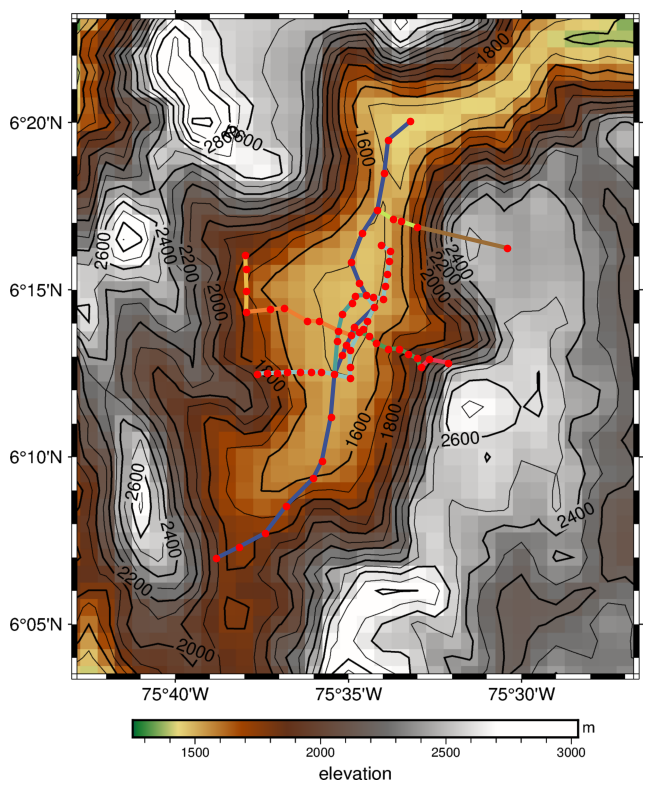

In [7]:
# Create a Matplotlib figure for overlaying NetworkX plot
plt.figure(figsize=(15,10))

# Load the saved PyGMT image
img = plt.imread('heat_altitude.png')
plt.imshow(img, extent = region)

# Assuming you have a NetworkX graph G and positions pos
pos = nx.get_node_attributes(G, 'pos')

# Draw the NetworkX graph on top of the PyGMT image
nx.draw(G, pos, with_labels=False, node_size=20, node_color='red',
        width=3,
        edge_color=list(nx.get_edge_attributes(G,'edge_color').values()))

# Adjust plot margins
plt.margins(0.1)

# Show the final combined plot
plt.show()


# How is the population distributed in the communas?

,MUNICIPIO,Macrozona _shapefile,geometry
0,ITAGUI,1.0,"POLYGON ((-75.61279 6.18084, -75.61243 6.18052..."
1,ITAGUI,2.0,"POLYGON ((-75.61284 6.18427, -75.61274 6.18419..."
2,La Estrella,25.0,"POLYGON ((-75.64759 6.16577, -75.64759 6.16572..."
3,Bello,6.0,"POLYGON ((-75.57469 6.36276, -75.57469 6.36271..."
4,Bello,5.0,"POLYGON ((-75.56883 6.35035, -75.56894 6.35034..."


,comuna name,comuna_index,municipality,muni_index,comuna longitude,comuna latitude,Macrozona _shapefile
0,Itagui-Comuna 06 ',1,'Itagui',8,-75.61493,6.176629,1
1,Itagui-Comuna 05 ',2,'Itagui',8,-75.60698,6.180733,2
2,Urbana La Estrella ',3,'La Estrella',9,-75.63781,6.142994,25
3,Bello-Comuna 06 ',4,'Bello',3,-75.56693,6.352998,6
4,Bello-Comuna 05 ',5,'Bello',3,-75.56992,6.341258,5


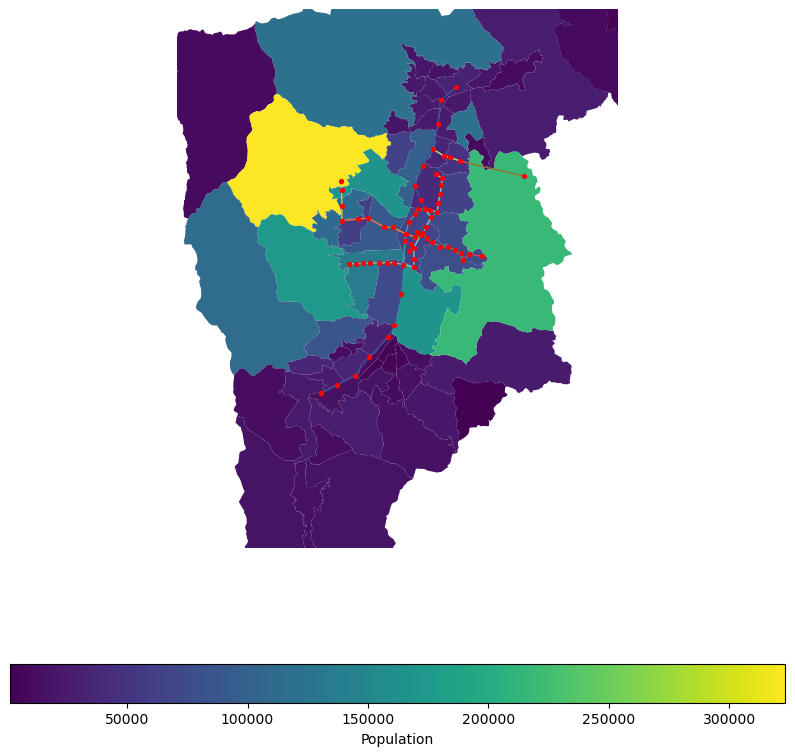

In [12]:
gdf = gpd.read_file('./communas_boundaries/MACROZONAS.shp')
gdf = gdf.rename(columns={'MACROZONA':'Macrozona _shapefile'})
display(gdf.head())

communa = pd.read_csv('./comunas.csv')
display(communa.head())
communa = communa.merge(gdf, on='Macrozona _shapefile')
communa.head()

pop_data = pd.read_csv('./comunas_pop.csv')
pop_data.head()

communa = communa.merge(pop_data, on='comuna_index')
#communa.head()

# Get positions for all nodes
pos = nx.get_node_attributes(G, 'pos')

communa = gpd.GeoDataFrame(communa, geometry=communa['geometry'])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
communa.plot(column='population',
             ax=ax, legend=True,
             legend_kwds={'label': "Population",
                      'orientation': "horizontal"},
             cmap='viridis'
            )
nx.draw(G, pos, ax=ax, with_labels=False, node_size=8, node_color='red',
        edge_color=list(nx.get_edge_attributes(G,'edge_color').values()))

ax.set(xlim=(region[0], region[1]),
       ylim=(region[2], region[3]))
#plt.savefig('metromap.png', format='png',dpi=300)
plt.show()